In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0,'../code')

In [3]:
import pytorch_lightning as pl
import torch
seed = pl.seed_everything(25)

/home/angelos/anaconda3/envs/dl2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 25


In [4]:
from argparse import Namespace
args = Namespace(
    base_model="ViT",
    checkpoint="../checkpoints/ViT_toy 3x3/epoch=99-step=15000.ckpt",
    from_pretrained="../checkpoints/ViT_toy 3x3",
    weighted_layer_distribution=True,
    dataset="toy",
    class_idx=3,
    grid_size=3,
    batch_size=5,
    add_noise=False,
    add_rotation=False,
    add_blur=False,
    num_workers=4,
)

### Load model from checkpoint

In [5]:
from models.interpretation import ImageInterpretationNet
from transformers import ViTForImageClassification
from attributions.grad_cam import grad_cam
from attributions.attention_rollout import attention_rollout
from attributions.chefer import chefer_attributions

In [6]:
# Initialize the ViT and DiffMask models from the checkpoint
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
vit_model = ViTForImageClassification.from_pretrained(args.from_pretrained)
diffmask_model = ImageInterpretationNet.load_from_checkpoint(
    args.checkpoint,
    model_cfg=vit_model.config,
)
diffmask_model.set_vision_transformer(vit_model)
diffmask_model.eval();
_ = vit_model.vit.eval()

OSError: We couldn't connect to 'https://huggingface.co' to load this model, couldn't find it in the cached files and it looks like ../checkpoints/ViT_toy 3x3 is not the path to a directory containing a config.json file.
Checkout your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/transformers/installation#offline-mode'.

### Generate sample images

In [7]:
from datamodules.utils import datamodule_factory

In [95]:
dm = datamodule_factory(args)
dm.prepare_data()
dm.setup("test")
X, Y = next(iter(dm.test_dataloader()))

### Compute DiffMask masks

In [96]:
out = diffmask_model.get_mask(X)
diff_masks = out["mask"].detach()

### Compute Gradcam masks

In [97]:
X_gradcam = X.clone()
X_gradcam = X_gradcam.to(device)
X_gradcam.requires_grad = True
gradcam_masks = grad_cam(X_gradcam, vit_model, use_cuda=True if device == "cuda" else False)


In [98]:
X_attention_rollout = X.clone()
B, C, H, W = X_attention_rollout.shape
X_attention_rollout = torch.cat([torch.zeros(1, C, H, W), X_attention_rollout], dim=0)
rollout_masks = attention_rollout(X_attention_rollout, vit=vit_model, device=device)
rollout_masks = rollout_masks[1:]

### Visualize results

In [99]:
from utils.plot import draw_mask_on_image, unnormalize, draw_heatmap_on_image
import matplotlib.pyplot as plt
import torch

In [100]:
def add_transparency(image):
    t_zero = torch.tensor(0.)

    C, H, W = image.shape
    image = image.reshape(C, -1)
    for i, patch in enumerate(image.sum(dim=0)):
        if patch.sum().allclose(t_zero):
            image[:, i] = 1

    return image.reshape(C, H, W)

def get_classname(idx):
    if hasattr(dm.feature_extractor, "id2label"):
        return dm.feature_extractor.id2label[idx]
    elif idx == 1:
        return "1 instance"
    else:
        return f"{idx} instances"

def plot(ax, image, ylabel, cmap=None, *args, **kwargs):
    if len(image.shape) == 3:
        image = image.permute(1, 2, 0)
    cb = ax.imshow(image, cmap, norm)
    ax.set_xticks([])
    ax.set_yticks([])
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=14)
    return cb

<Figure size 432x288 with 0 Axes>

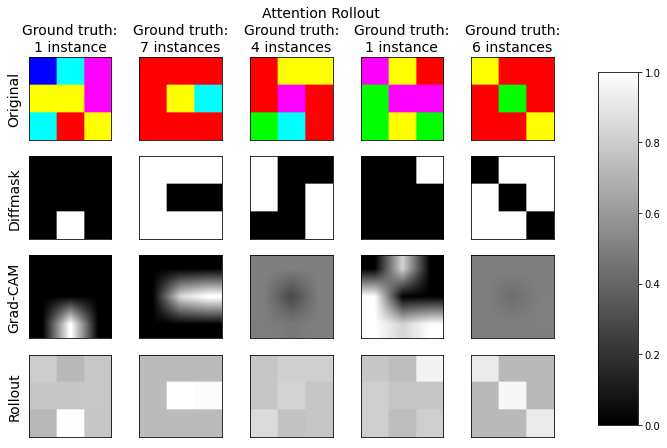

In [101]:
plt.clf()
fig, axs = plt.subplots(4, len(X), figsize=(11, 7))
import matplotlib
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)

masks = [diff_masks, gradcam_masks, rollout_masks]
cmap = "gray"
for j, m in enumerate(masks):
    for i, (img, mask, y) in enumerate(zip(
        unnormalize(X), m, Y)):
        label1 = "Original" if i == 0 else None
        label2 = "Diffmask" if i == 0 else None
        label3 = "Grad-CAM" if i == 0 else None
        label4 = "Rollout" if i == 0 else None
        if j == 0:
            plot(axs[0][i], img, label1)
        if j == 0:
            cb1 = plot(axs[1][i], mask, label2, cmap=cmap, norm=norm)
        if j == 1:
            cb2 = plot(axs[2][i], mask, label3, cmap=cmap, norm=norm)
        if j == 2:
            cb3 = plot(axs[3][i], mask, label4, cmap=cmap, norm=norm)
        axs[0][i].set_title(f"Ground truth:\n{get_classname(y.item())}", fontsize=14)

fig.subplots_adjust(right=0.8)
cbar_ax1 = fig.add_axes([0.85, 0.15, 0.05, 0.7])


fig.colorbar(cb1, cax=cbar_ax1, orientation="vertical")

plt.suptitle("Attention Rollout", fontsize=14)
plt.savefig("toy.eps", dpi=300)

In [102]:
def aug_smooth(X: torch.tensor, method='diffmask'):
    Xs = []
    for flips in [0, 1]:
        for multiplications in (1, 1.1, 0.9):
            if method == 'diffmask':
                mask = diffmask_model.get_mask(
                    (torch.flip(X, dims=(2,)) if flips else X) * multiplications
                )["mask"].detach()
            elif method == 'gradcam':
                mask = gradcam_masks = grad_cam(X_gradcam, vit_model, use_cuda=True if device == "cuda" else False)
            elif method == 'rollout':
                B, C, H, W = X.shape
                X_attention_rollout = torch.cat([torch.zeros(1, C, H, W), X], dim=0)
                rollout_masks = attention_rollout(X, vit=vit_model, device=device)
                mask = rollout_masks[1:]
            Xs.append(mask)
    Xs = torch.mean(torch.stack(Xs, dim=0), dim=0)
    return Xs

def aug_smooth_diffmask(X):
    Xs = []
    for flips in [0, 1]:
        for multiplications in (1, 1.1, 0.9):
            mask = diffmask_model.get_mask(
                (torch.flip(X, dims=(2,)) if flips else X) * multiplications
            )["mask"].detach()
            Xs.append(mask)
    Xs = torch.mean(torch.stack(Xs, dim=0), dim=0)
    return Xs